# Hardcoded variables (file paths, GPS times, sample rate etc)

In [1]:
####################################

trigtime=1167559936.6
epoch=1167559934.6
datalen=4
srate=2048
nsamples=1000
delta_t=1./srate
ifos=['H1', 'L1']
nr_fmin = 30.0
passband=[30,300]
approx="IMRPhenomPv2andSEOBNRv3"
import numpy as np
overlap_bins = np.linspace(-1,1.01,100)
inset_bins = np.linspace(0.9,1.01,50)

####################################

nr_root="/Users/jclark/Projects/NRwaves"
results_root="/Users/jclark/Projects/reconstruction-data/GW170104/onsource"

nr_waves_file = "{}/NRwaves.pickle".format(nr_root)
li_waveforms_file="{0}/{1}_waveforms_big.npy".format(nr_root,approx)
li_waveforms_raw_file="{0}/{1}_raw_waveforms_big.npy".format(nr_root,approx)

data_files = ["{0}/whitened_data.dat.{1}".format(results_root, r) for r in xrange(2)]
              
summary_files = ["{0}/{1}/H1_summary_waveforms.txt".format(results_root, approx),
            "{0}/{1}/L1_summary_waveforms.txt".format(results_root, approx)]



# Dependencies and Definitions

In [2]:
# GW170104 Reconstructions

import os, sys
import numpy as np
import cPickle as pickle
from matplotlib import pyplot as plt
from pycbc import filter
from pycbc.types import TimeSeries
import filt
from string import ascii_lowercase
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

waveform_labels = [val for val in ascii_lowercase]+[2*val for val in ascii_lowercase]


# Plotting Configuration
fig_width_pt = 246.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inches
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height =fig_width*golden_mean       # height in inches
fig_size = [fig_width,fig_height]
params = {
          'axes.labelsize': 8,
          'font.size': 8,
          'legend.fontsize': 8,
          'xtick.color': 'k',
          'xtick.labelsize': 8,
          'ytick.color': 'k',
          'ytick.labelsize': 8,
          'text.usetex': True,
          'text.color': 'k',
          'figure.figsize': fig_size
          }
import pylab
pylab.rcParams.update(params)


# Adjust times so that zero is on an integer second)
local_times = np.arange(epoch, epoch+datalen, 1./srate)-trigtime
trigtime,delta = divmod(trigtime,1)
local_times += delta
import subprocess
command = ['lalapps_tconvert', str(int(trigtime))]
p = subprocess.Popen(command, stdout=subprocess.PIPE)
timestr = p.stdout.read().replace('\n','')


def network_overlap(ts1_list, ts2_list, f_low=20.0):
    """ 
    Compute network overlap
    """
    overlap_sum=0.
    overlap_sum = sum([filter.overlap(ts1, ts2,
        low_frequency_cutoff=f_low, normalized=False) for ts1,ts2 in
        zip(ts1_list,ts2_list)])
    norm1 = sum([filter.overlap(ts1, ts2,
        low_frequency_cutoff=f_low, normalized=False) for ts1,ts2 in
        zip(ts1_list,ts1_list)])
    norm2 = sum([filter.overlap(ts1, ts2,
        low_frequency_cutoff=f_low, normalized=False) for ts1,ts2 in
        zip(ts2_list,ts2_list)])

    net_overlap = overlap_sum / np.sqrt(norm1*norm2)

    return net_overlap

def update_progress(progress):
    print '\r\r[{0}] {1}%'.format('#'*(progress/2)+' '*(50-progress/2), progress),
    if progress == 100:
        print "\nDone"
    sys.stdout.flush()

# Build a bandpass and notch filter to eliminate unsightly frequencies
filterBas = filt.get_filt_coefs(srate, min(passband), max(passband), False, False)
    

In [3]:

# Retrieve mass ratio, chi-eff samples
# from pylal import bayespputils as bppu
# print "parsing posterior samples"
# peparser = bppu.PEOutputParser('common')
# resultsObj = peparser.parse(open(posterior_samples_file,'r'))
# posterior = bppu.Posterior(resultsObj)
# print "%d posterior samples parsed"%len(posterior)

## Load Data

### BayesWave

In [4]:
# BayesWave Samples
bw_infile_fmt = os.path.join(results_root,
        'signal_recovered_whitened_waveform.dat.{}')
bw_infiles = [bw_infile_fmt.format(ifo) for ifo in xrange(len(ifos))]
print "Loading BayesWave results"
bw_waves = np.array([np.loadtxt(infile) for infile in bw_infiles])
print "...loaded"

print "Loading whitened data"
# BayesWave whitened data
white_data = [TimeSeries(np.loadtxt(file), delta_t=delta_t) for file in data_files]
print "...loaded"

Loading BayesWave results
...loaded
Loading whitened data
...loaded


### LALInference

In [5]:
# LALInference Samples
print "Loading LALInference results"
li_waves = np.load(li_waveforms_file)
li_waves_raw = np.load(li_waveforms_raw_file)
print "...loaded"

# LALInference summary
print "Loading LALInference summary waveforms"


f = open(summary_files[0],'r')
header = f.readline().replace('#','').split()
f.close()

li_MAP_waves = [TimeSeries(np.loadtxt(summary_file,
    usecols=[header.index('whitened_MAP')]), delta_t=1./srate,
    epoch=epoch) for summary_file in summary_files]

li_MAP_waves_raw = [TimeSeries(np.loadtxt(summary_file,
    usecols=[header.index('whitened_MAP')]), delta_t=1./srate,
    epoch=epoch) for summary_file in summary_files]

li_ML_waves = [TimeSeries(np.loadtxt(summary_file,
    usecols=[header.index('whitened_ML')]), delta_t=1./srate,
    epoch=epoch) for summary_file in summary_files]

li_ML_waves_raw = [TimeSeries(np.loadtxt(summary_file,
    usecols=[header.index('whitened_ML')]), delta_t=1./srate,
    epoch=epoch) for summary_file in summary_files]

print "...loaded"



Loading LALInference results
...loaded
Loading LALInference summary waveforms
...loaded


### Numerical Relativity

In [6]:
# NR waveforms
print "loading NR waveforms and parameters"
nr_waves_dict = pickle.load(open(nr_waves_file, 'rb'))
print "...loaded"

nNRwaves = len(nr_waves_dict.keys())


nr_waves_raw = np.zeros(shape=(nNRwaves,2,srate*datalen))
nr_waves = np.zeros(shape=(nNRwaves,2,srate*datalen))
for n,nr_wave in enumerate(nr_waves_dict.keys()):
    nr_waves_raw[n] = nr_waves_dict[nr_wave][0]
    nr_waves[n] = nr_waves_dict[nr_wave][1]


loading NR waveforms and parameters
...loaded


In [7]:
print nNRwaves
print len(waveform_labels)
print "|| '''Label''' || '''Waveform''' ||"
for l,key in zip(waveform_labels,nr_waves_dict.keys()):
    print "|| {} || {} ||".format(l, key)

31
52
|| '''Label''' || '''Waveform''' ||
|| a || RIT-Generic_D14.53_q0.7147_a0.2205_-0.7110_opt2_n100 ||
|| b || RIT-Generic_D13.50_q0.4300_a-0.3634_-0.1256_opt2_n118 ||
|| c || GT-Aligned-UnequalMass_-0.2-1-M200-D11 ||
|| d || RIT-Kicks_q50_a0_a8_th_135_ph_30 ||
|| e || RIT-Kicks_q200_a8_a0_th_135_ph_120 ||
|| f || SXS-All_52 ||
|| g || LVC-GitAnnex_SXS_BBH_0628_Res3.h5 ||
|| h || RIT-Generic_d0_D10.52_q1.3333_a-0.25_n100 ||
|| i || SXS-All_BBH_CFMS_d16.8_q2_sA_0_0_-0.300_sB_0_0_-0.300 ||
|| j || RIT-Generic_D13.03_UID3_q0.48_a1_0.08_-0.40_-0.30_a2_-0.38_0.75_-0.10_opt2_n100 ||
|| k || RIT-Kicks_q50_a0_a8_th_135_ph_0 ||
|| l || RIT-Generic_D14.66_q0.8514_a0.7343_-0.8267_opt2_n100 ||
|| m || GT-Aligned-UnequalMass_-0.4-1-M200-D11 ||
|| n || GT-Aligned-UnequalMass_0.0-1.15 ||
|| o || RIT-Generic_D11.92_UID2_q0.52_a1_0.16_-0.10_-0.05_a2_-0.36_0.57_-0.35_opt2_n100 ||
|| p || LVC-GitAnnex_SXS_BBH_0627_Res3.h5 ||
|| q || LVC-GitAnnex_SXS_BBH_0625_Res3.h5 ||
|| r || RIT-Kicks_q200_a8_a0_th_

# Calculations

## Waveform Credible Intervals

In [8]:

# Reconstruction confidence belts
li_intervals = [ np.percentile(li_waves[i], 
                               [5, 50, 95], axis=0)
                               for i in xrange(2) ]
li_intervals_raw = [ np.percentile(li_waves_raw[i], 
                                   [5, 50, 95], axis=0)
                               for i in xrange(2) ]



## Overlaps

### NR vs approximant

In [9]:
# Compute NR-sample overlaps
li_nr_overlaps=np.zeros(shape=(nNRwaves,nsamples))
li_nr_overlaps_h=np.zeros(shape=(nNRwaves,nsamples))
li_nr_overlaps_l=np.zeros(shape=(nNRwaves,nsamples))

MAP_nr_overlaps=np.zeros(shape=(nNRwaves))
MAP_nr_overlaps_h=np.zeros(shape=(nNRwaves))
MAP_nr_overlaps_l=np.zeros(shape=(nNRwaves))

ML_nr_overlaps=np.zeros(shape=(nNRwaves))
ML_nr_overlaps_h=np.zeros(shape=(nNRwaves))
ML_nr_overlaps_l=np.zeros(shape=(nNRwaves))

for n,nr_wave in enumerate(nr_waves_dict.keys()):
    print "Overlaps for {0} ({1} of {2})".format(nr_wave, n, nNRwaves)
    
    nr_white = [ TimeSeries(nrw, delta_t=delta_t) 
                      for nrw in nr_waves[n] ]
    
    MAP_nr_overlaps[n] = network_overlap(nr_white, li_MAP_waves, f_low=nr_fmin)
    MAP_nr_overlaps_h[n] = filter.overlap(nr_white[0], li_MAP_waves[0], low_frequency_cutoff=nr_fmin)
    MAP_nr_overlaps_l[n] = filter.overlap(nr_white[1], li_MAP_waves[1], low_frequency_cutoff=nr_fmin)
     
    ML_nr_overlaps[n] = network_overlap(nr_white, li_ML_waves, f_low=nr_fmin)
    ML_nr_overlaps_h[n] = filter.overlap(nr_white[0], li_ML_waves[0], low_frequency_cutoff=nr_fmin)
    ML_nr_overlaps_l[n] = filter.overlap(nr_white[1], li_ML_waves[1], low_frequency_cutoff=nr_fmin)
    
    for s in xrange(nsamples):
    
        liw = [ TimeSeries(waves[s], delta_t=delta_t) 
                       for waves in li_waves ]
        
        li_nr_overlaps[n,s]   = network_overlap(nr_white, liw, f_low=nr_fmin)
        li_nr_overlaps_h[n,s] = filter.overlap(nr_white[0], liw[0], 
                                             low_frequency_cutoff=nr_fmin)
        li_nr_overlaps_l[n,s] = filter.overlap(nr_white[1], liw[1], 
                                             low_frequency_cutoff=nr_fmin)


Overlaps for RIT-Generic_D14.53_q0.7147_a0.2205_-0.7110_opt2_n100 (0 of 31)
Overlaps for RIT-Generic_D13.50_q0.4300_a-0.3634_-0.1256_opt2_n118 (1 of 31)
Overlaps for GT-Aligned-UnequalMass_-0.2-1-M200-D11 (2 of 31)
Overlaps for RIT-Kicks_q50_a0_a8_th_135_ph_30 (3 of 31)
Overlaps for RIT-Kicks_q200_a8_a0_th_135_ph_120 (4 of 31)
Overlaps for SXS-All_52 (5 of 31)
Overlaps for LVC-GitAnnex_SXS_BBH_0628_Res3.h5 (6 of 31)
Overlaps for RIT-Generic_d0_D10.52_q1.3333_a-0.25_n100 (7 of 31)
Overlaps for SXS-All_BBH_CFMS_d16.8_q2_sA_0_0_-0.300_sB_0_0_-0.300 (8 of 31)
Overlaps for RIT-Generic_D13.03_UID3_q0.48_a1_0.08_-0.40_-0.30_a2_-0.38_0.75_-0.10_opt2_n100 (9 of 31)
Overlaps for RIT-Kicks_q50_a0_a8_th_135_ph_0 (10 of 31)
Overlaps for RIT-Generic_D14.66_q0.8514_a0.7343_-0.8267_opt2_n100 (11 of 31)
Overlaps for GT-Aligned-UnequalMass_-0.4-1-M200-D11 (12 of 31)
Overlaps for GT-Aligned-UnequalMass_0.0-1.15 (13 of 31)
Overlaps for RIT-Generic_D11.92_UID2_q0.52_a1_0.16_-0.10_-0.05_a2_-0.36_0.57_-0.35_

### MAP vs other samples

In [10]:
# Pick 2 sets of random LALInference waveforms

# Compute waveform-MAP overlaps
li_MAP_overlaps=np.zeros(nsamples)
li_MAP_overlaps_h=np.zeros(nsamples)
li_MAP_overlaps_l=np.zeros(nsamples)

print "computing LALInference Overlaps"
# li_MAP_waves

for w in xrange(nsamples):
    
    if li_waves[0][0][0] == li_MAP_waves[0][0]:
        print "H1: DANGER"
        sys.exit()
    if li_waves[1][0][0] == li_MAP_waves[1][0]:
        print "L1: DANGER"
        sys.exit()
    
    # LALInference
    waveforms = [ TimeSeries(waves[w], delta_t=delta_t) 
                   for waves in li_waves ]
    
    li_MAP_overlaps[w] = network_overlap(waveforms, li_MAP_waves, 
                                          f_low=nr_fmin)
    li_MAP_overlaps_h[w] = filter.overlap(waveforms[0], li_MAP_waves[0], 
                                           low_frequency_cutoff=nr_fmin)
    li_MAP_overlaps_l[w] = filter.overlap(waveforms[1], li_MAP_waves[1], 
                                           low_frequency_cutoff=nr_fmin)
    

computing LALInference Overlaps


## Signal To Noise Ratios

### Approximant Signal-to-Noise Ratios

In [11]:
print "computing LALInference SNRs"

fftnorm = 1./srate * np.sqrt(float(len(li_ML_waves[0]))/2)

# --- ML
ML_snr_h = filter.matched_filter(li_ML_waves[0], white_data[0], 
                                 low_frequency_cutoff=nr_fmin)/fftnorm
ML_snr_l = filter.matched_filter(li_ML_waves[1], white_data[1], 
                                 low_frequency_cutoff=nr_fmin)/fftnorm
ML_snr = max(abs(np.sqrt(ML_snr_h**2 + ML_snr_l**2)))

# --- MAP
MAP_snr_h = filter.matched_filter(li_MAP_waves[0], white_data[0], 
                                 low_frequency_cutoff=nr_fmin)/fftnorm
MAP_snr_l = filter.matched_filter(li_MAP_waves[1], white_data[1], 
                                 low_frequency_cutoff=nr_fmin)/fftnorm
MAP_snr = max(abs(np.sqrt(MAP_snr_h**2+ MAP_snr_l**2)))
print "...done"

computing LALInference SNRs
...done


### NR signal-to-noise ratios

In [12]:
NR_snr_h = np.zeros(nNRwaves)
NR_snr_l = np.zeros(nNRwaves)
NR_snr = np.zeros(nNRwaves)

print "NR SNRs..."

for n,nr_wave in enumerate(nr_waves_dict.keys()):
    
    print "snr for {}".format(nr_wave)
    
    nr_white = [ TimeSeries(nrw, delta_t=delta_t) 
                      for nrw in nr_waves[n] ]
    
    h = filter.matched_filter(nr_white[0],white_data[0],low_frequency_cutoff=nr_fmin)/fftnorm
    NR_snr_h[n] = max(abs(h))
    l = filter.matched_filter(nr_white[1],white_data[1],low_frequency_cutoff=nr_fmin)/fftnorm
    NR_snr_l[n] = max(abs(l))
    NR_snr[n] = max(abs(np.sqrt(h**2+l**2)))

print "...done"

NR SNRs...
snr for RIT-Generic_D14.53_q0.7147_a0.2205_-0.7110_opt2_n100
snr for RIT-Generic_D13.50_q0.4300_a-0.3634_-0.1256_opt2_n118
snr for GT-Aligned-UnequalMass_-0.2-1-M200-D11
snr for RIT-Kicks_q50_a0_a8_th_135_ph_30
snr for RIT-Kicks_q200_a8_a0_th_135_ph_120
snr for SXS-All_52
snr for LVC-GitAnnex_SXS_BBH_0628_Res3.h5
snr for RIT-Generic_d0_D10.52_q1.3333_a-0.25_n100
snr for SXS-All_BBH_CFMS_d16.8_q2_sA_0_0_-0.300_sB_0_0_-0.300
snr for RIT-Generic_D13.03_UID3_q0.48_a1_0.08_-0.40_-0.30_a2_-0.38_0.75_-0.10_opt2_n100
snr for RIT-Kicks_q50_a0_a8_th_135_ph_0
snr for RIT-Generic_D14.66_q0.8514_a0.7343_-0.8267_opt2_n100
snr for GT-Aligned-UnequalMass_-0.4-1-M200-D11
snr for GT-Aligned-UnequalMass_0.0-1.15
snr for RIT-Generic_D11.92_UID2_q0.52_a1_0.16_-0.10_-0.05_a2_-0.36_0.57_-0.35_opt2_n100
snr for LVC-GitAnnex_SXS_BBH_0627_Res3.h5
snr for LVC-GitAnnex_SXS_BBH_0625_Res3.h5
snr for RIT-Kicks_q200_a8_a0_th_135_ph_150
snr for SXS-All_BBH_CFMS_d16.5_q2_sA_0_0_-0.300_sB_0_0_0
snr for RIT-Ge

## SNR & Overlap Text Summary

In [13]:
print "=== {} SNR/Overlap Summary ===".format(approx)

print "SNRs and overlaps evaluated from {:.0f} Hz".format(nr_fmin)

print "==== Max-likelihood SNRs ===="
print "||'''H1 SNR''' ||'''L1 SNR''' ||'''Network SNR''' ||"
print "|| {0:.2f} || {1:.2f} || {2:.2f} ||".format(
    max(abs(ML_snr_h)),max(abs(ML_snr_l)),ML_snr)
print ""
print "==== Max A Posteriori SNRs ===="
print "||'''H1 SNR''' ||'''L1 SNR''' ||'''Network SNR''' ||"
print "|| {0:.2f} || {1:.2f} || {2:.2f} ||".format(
    max(abs(MAP_snr_h)),max(abs(MAP_snr_l)),MAP_snr)

print "==== NR Waveforms ===="
print " * Overlaps are between the NR waveform and the '''max-likelihood''' waveform recovered by {}".format(approx)
print "|| '''Label'''|| '''Waveform''' || '''H1 SNR''' || '''H1 overlap''' ||'''L1 SNR''' || '''L1 overlap''' ||'''Network SNR''' || '''Network Overlap''' ||"

for n,(label,key) in enumerate(zip(waveform_labels,nr_waves_dict.keys())):
    print "|| {label} || {waveform} || {h1snr:.2f} || {h1overlap:.2f} || {l1snr:.2f} || {l1overlap:.2f} || {netsnr:.2f} || {netoverlap:.2f} ||".format(
        label=label, waveform=key.replace('-lmax3',''),
        h1snr=NR_snr_h[n], h1overlap=ML_nr_overlaps_h[n],
        l1snr=NR_snr_l[n], l1overlap=ML_nr_overlaps_l[n],
        netsnr=NR_snr[n], netoverlap=ML_nr_overlaps[n])
        



=== IMRPhenomPv2andSEOBNRv3 SNR/Overlap Summary ===
SNRs and overlaps evaluated from 30 Hz
==== Max-likelihood SNRs ====
||'''H1 SNR''' ||'''L1 SNR''' ||'''Network SNR''' ||
|| 8.46 || 10.56 || 13.47 ||

==== Max A Posteriori SNRs ====
||'''H1 SNR''' ||'''L1 SNR''' ||'''Network SNR''' ||
|| 8.70 || 10.31 || 13.43 ||
==== NR Waveforms ====
 * Overlaps are between the NR waveform and the '''max-likelihood''' waveform recovered by IMRPhenomPv2andSEOBNRv3
|| '''Label'''|| '''Waveform''' || '''H1 SNR''' || '''H1 overlap''' ||'''L1 SNR''' || '''L1 overlap''' ||'''Network SNR''' || '''Network Overlap''' ||
|| a || RIT-Generic_D14.53_q0.7147_a0.2205_-0.7110_opt2_n100 || 8.46 || 0.97 || 9.99 || 0.94 || 13.09 || 0.95 ||
|| b || RIT-Generic_D13.50_q0.4300_a-0.3634_-0.1256_opt2_n118 || 8.45 || 0.94 || 10.19 || 0.95 || 13.07 || 0.94 ||
|| c || GT-Aligned-UnequalMass_-0.2-1-M200-D11 || 8.45 || 0.97 || 10.22 || 0.96 || 13.26 || 0.96 ||
|| d || RIT-Kicks_q50_a0_a8_th_135_ph_30 || 8.46 || 0.98 || 10.45

# Plotting

## Overlap distributions

### Violin Plot for MAP-Overlaps

(1000,)


/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


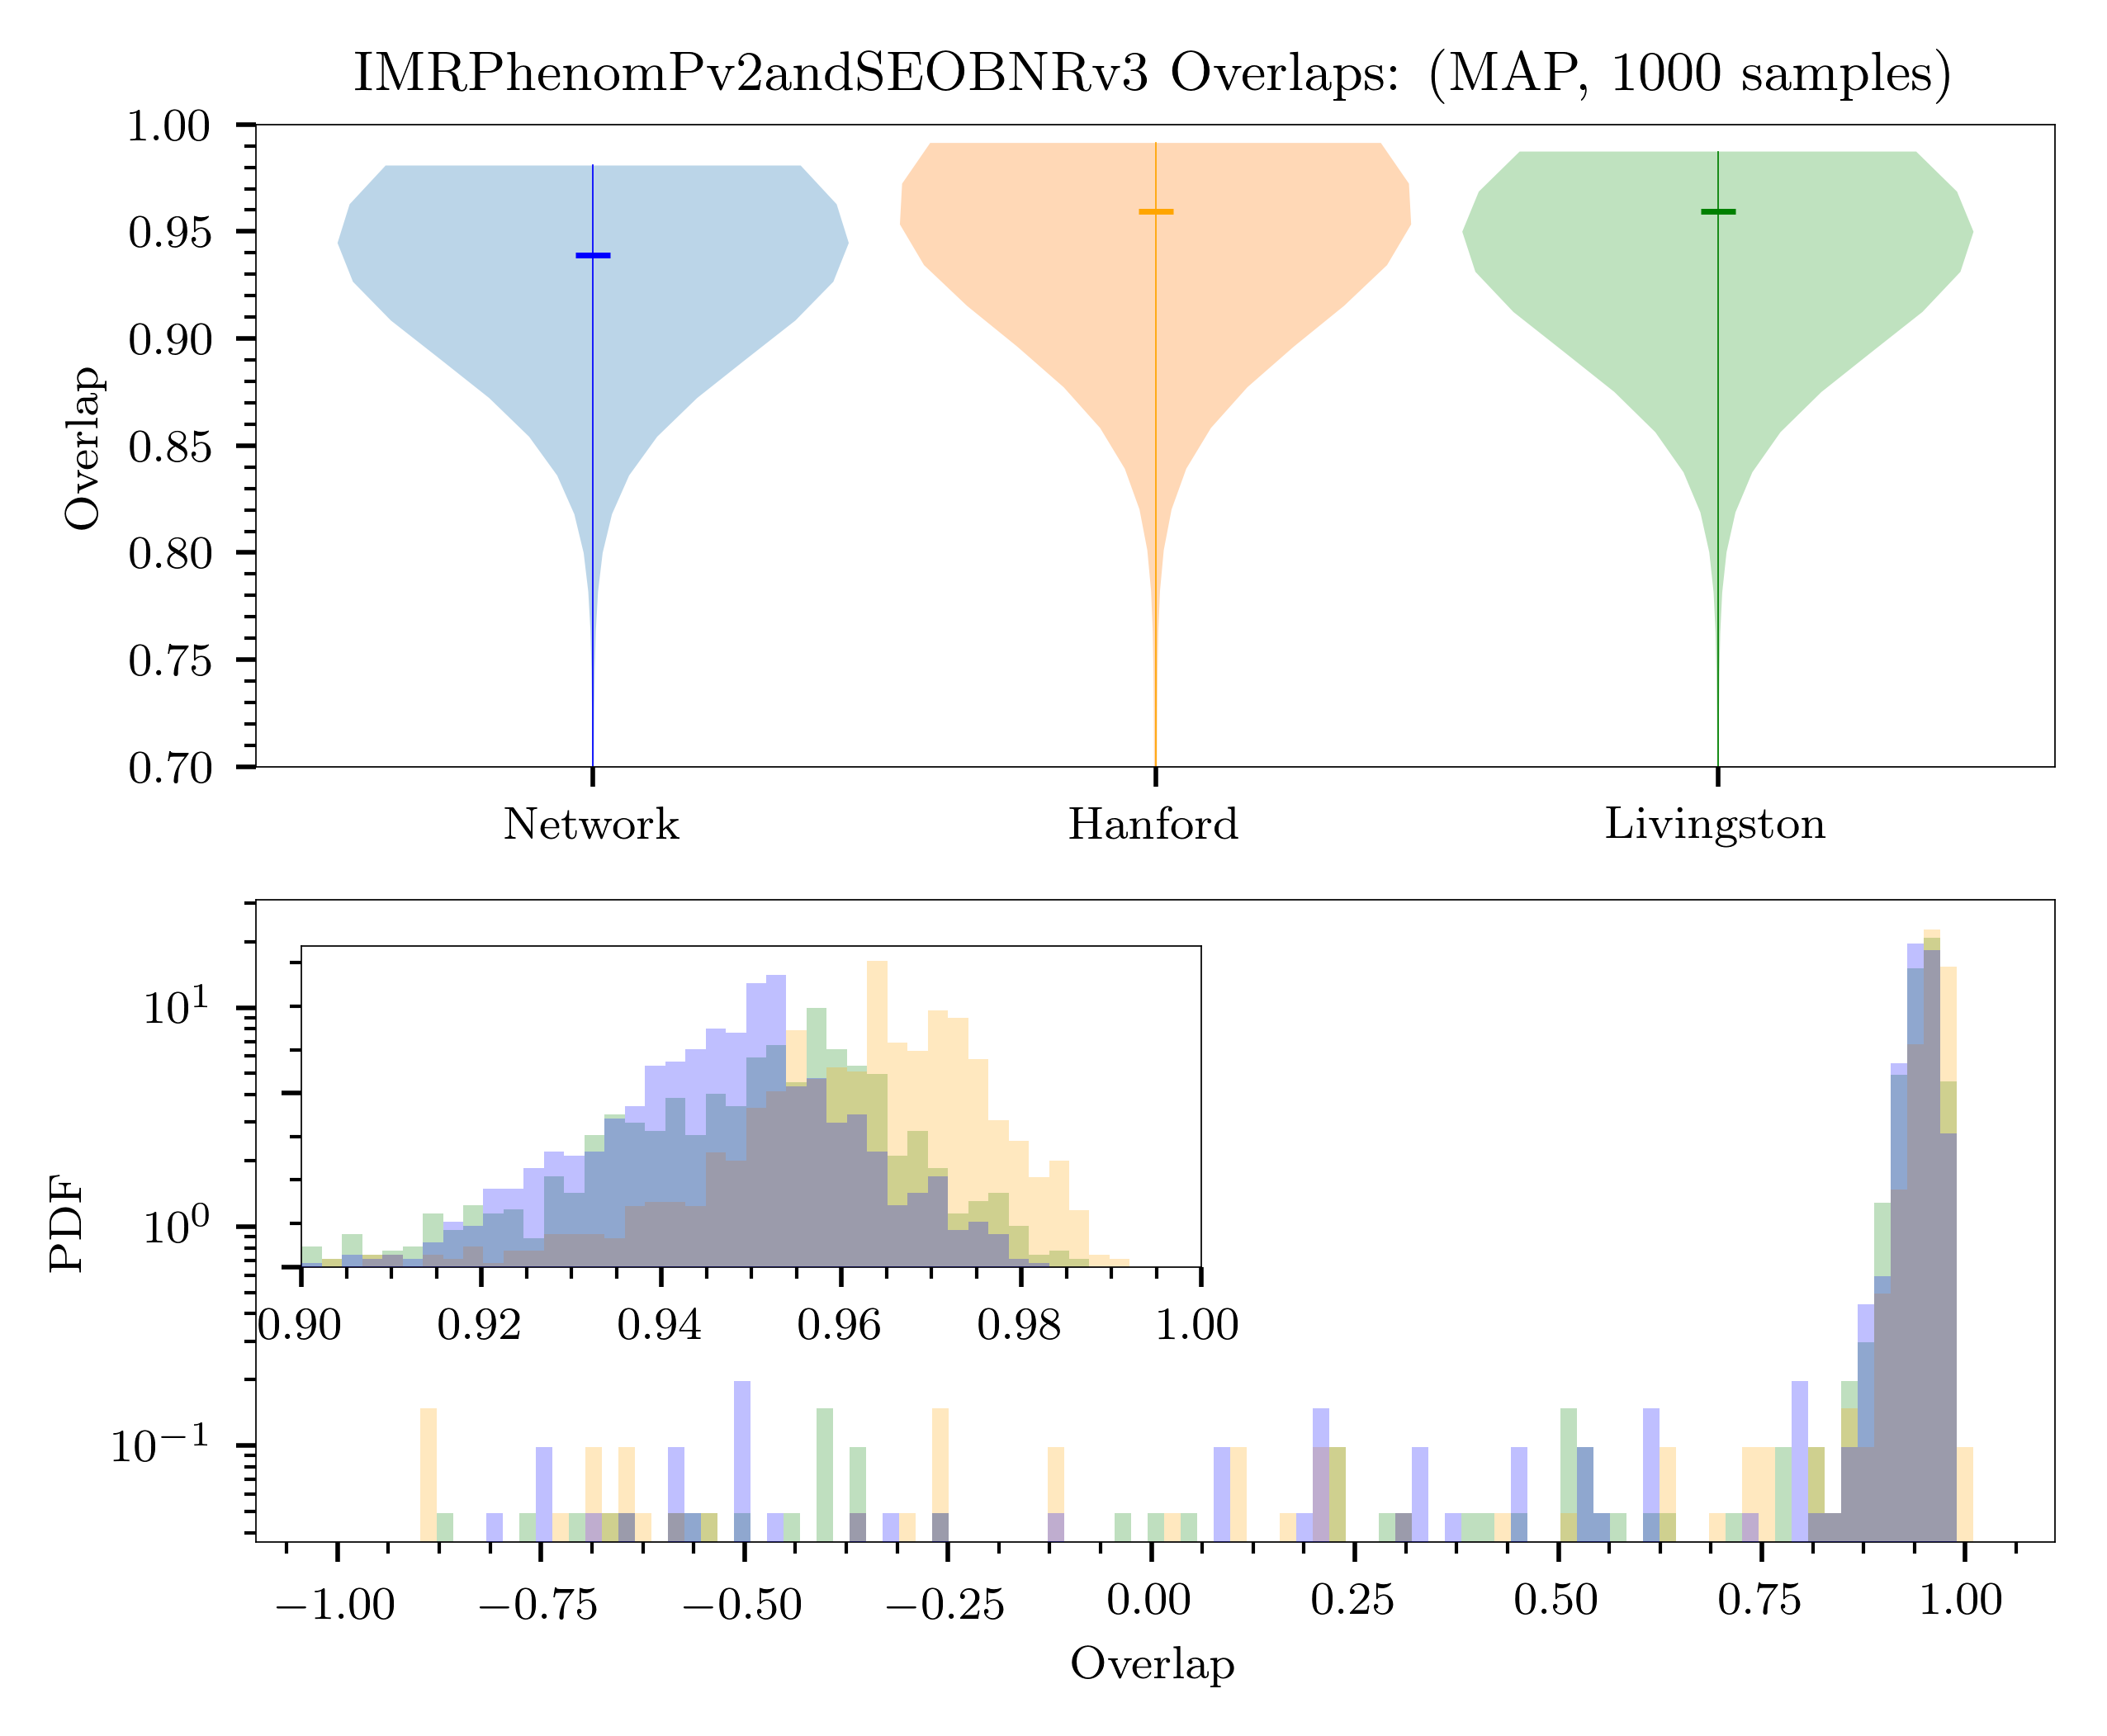

In [14]:
plt.close('all')
f, ax = plt.subplots(dpi=500, nrows=2, figsize=(1.5*fig_size[0], 2*fig_size[1]))
for axis in ['top','bottom','left','right']:
      ax[0].spines[axis].set_linewidth(0.25)
      ax[1].spines[axis].set_linewidth(0.25)
        
widths=5
left_positions = np.array([1])
center_positions = left_positions+widths+0.5
right_positions = center_positions+widths+0.5
single_positions = [center_positions, right_positions]


#sys.exit()
min = np.min
colors=['blue','orange','green']

ax[0].violinplot([li_MAP_overlaps], 
                 positions=left_positions,
                 showmeans=False, showmedians=False,
                 widths=widths, showextrema=False)

maxpt = max(li_MAP_overlaps)
minpt = min(li_MAP_overlaps)
ax[0].plot([left_positions, left_positions], [minpt, maxpt],
           color=colors[0], linewidth=0.25)

print np.shape(li_MAP_overlaps)

overlaps=[li_MAP_overlaps_h, li_MAP_overlaps_l]
for i in xrange(len(ifos)):
    ax[0].violinplot([overlaps[i]], 
                     positions=single_positions[i],
                     showmeans=False, showmedians=False,
                     widths=widths, showextrema=False)

    maxpt = max(overlaps[i])
    minpt = min(overlaps[i])
    # Plot extrema as *thin* vertical line
    ax[0].plot([single_positions[i], single_positions[i]], 
               [minpt, maxpt],
               color=colors[i+1], linewidth=0.25)
    # Plot peak


ax[0].minorticks_on()
ax[0].set_xticks([left_positions, center_positions, right_positions])

# ax[0].grid(which='major', color='gray', alpha=0.5)

labels = [r"$\textrm{Network}$", r"$\textrm{Hanford}$", r"$\textrm{Livingston}$"]
ax[0].set_xticklabels(labels)
ax[0].tick_params(which='minor',bottom="off")

ax[0].set_ylim(0.7,1)
ax[0].set_ylabel(r'$\textrm{Overlap}$')

# --- Histograms (also, draw peak locations on violins)  
        
n, bins, patches = ax[1].hist(li_MAP_overlaps, 
           histtype='stepfilled', alpha=0.25, bins=overlap_bins, normed=True,
           color=colors[0], zorder=3)
axins = inset_axes(ax[1], width="50%", height="50%", 
                       loc=2, borderpad=1)  
for axis in ['top','bottom','left','right']:
      axins.spines[axis].set_linewidth(0.25)
axins.hist(li_MAP_overlaps, 
           histtype='stepfilled', alpha=0.25, 
           bins=inset_bins, normed=True,
           color=colors[0], zorder=3)
axins.set_xlim(.9,1)


# draw a line on the violin plot with the peak location taken from the histogram
ax[0].plot(left_positions, 
           bins[1:][np.argmax(n)]-0.5*np.diff(bins[1:])[0], 
           color=colors[0], marker='_')

for i in xrange(len(ifos)):
    n, bins, patches = ax[1].hist(overlaps[i], 
               histtype='stepfilled', alpha=0.25, bins=overlap_bins,
               normed=True,
               color=colors[i+1], zorder=len(ifos)-i)
    axins.hist(overlaps[i], 
           histtype='stepfilled', alpha=0.25, 
           bins=inset_bins, normed=True,
           color=colors[i+1], zorder=len(ifos)-i)
    
    # draw a line on the violin plot with the peak location taken from the histogram
    ax[0].plot(single_positions[i], 
               bins[1:][np.argmax(n)]-0.5*np.diff(bins[1:])[0], 
               color=colors[i+1], marker='_')
    
ax[1].set_yscale('log')

ax[1].minorticks_on()
# ax[1].set_xlim(0.8,1)
axins.set_xlim(.9,1)
axins.set_yticklabels([])
axins.minorticks_on()

ax[1].spines['bottom'].set_visible(True)
# ax[1].grid(which='major', color='gray', alpha=0.5)
ax[1].set_xlabel(r'$\textrm{Overlap}$')
ax[1].set_ylabel(r'$\textrm{PDF}$')
ax[1].legend(loc='upper left')

ax[0].set_title(r"$\textrm{%s Overlaps: (MAP, %d samples)}$"%(approx, nsamples))
# namestr=r"$\textrm{%s Overlaps: (MAP, %d samples)}$"%(approx, nsamples)
# f.text(0.2, 0.875, namestr, 
#      va='center', rotation='horizontal')

ax[1].legend(bbox_to_anchor=(0., .99, 1., .102), loc=3,
              ncol=3, mode="expand", borderaxespad=0., 
              frameon=False)


f.tight_layout()

f.savefig("{}_MAPOverlapViolins.png".format(approx))
f.savefig("{}_MAPOverlapViolins.pdf".format(approx))
    
from IPython.display import Image, display
display(Image(filename="{}_MAPOverlapViolins.png".format(approx), width=600))



### Violin Plot For All NR waves

31
(31, 1000)


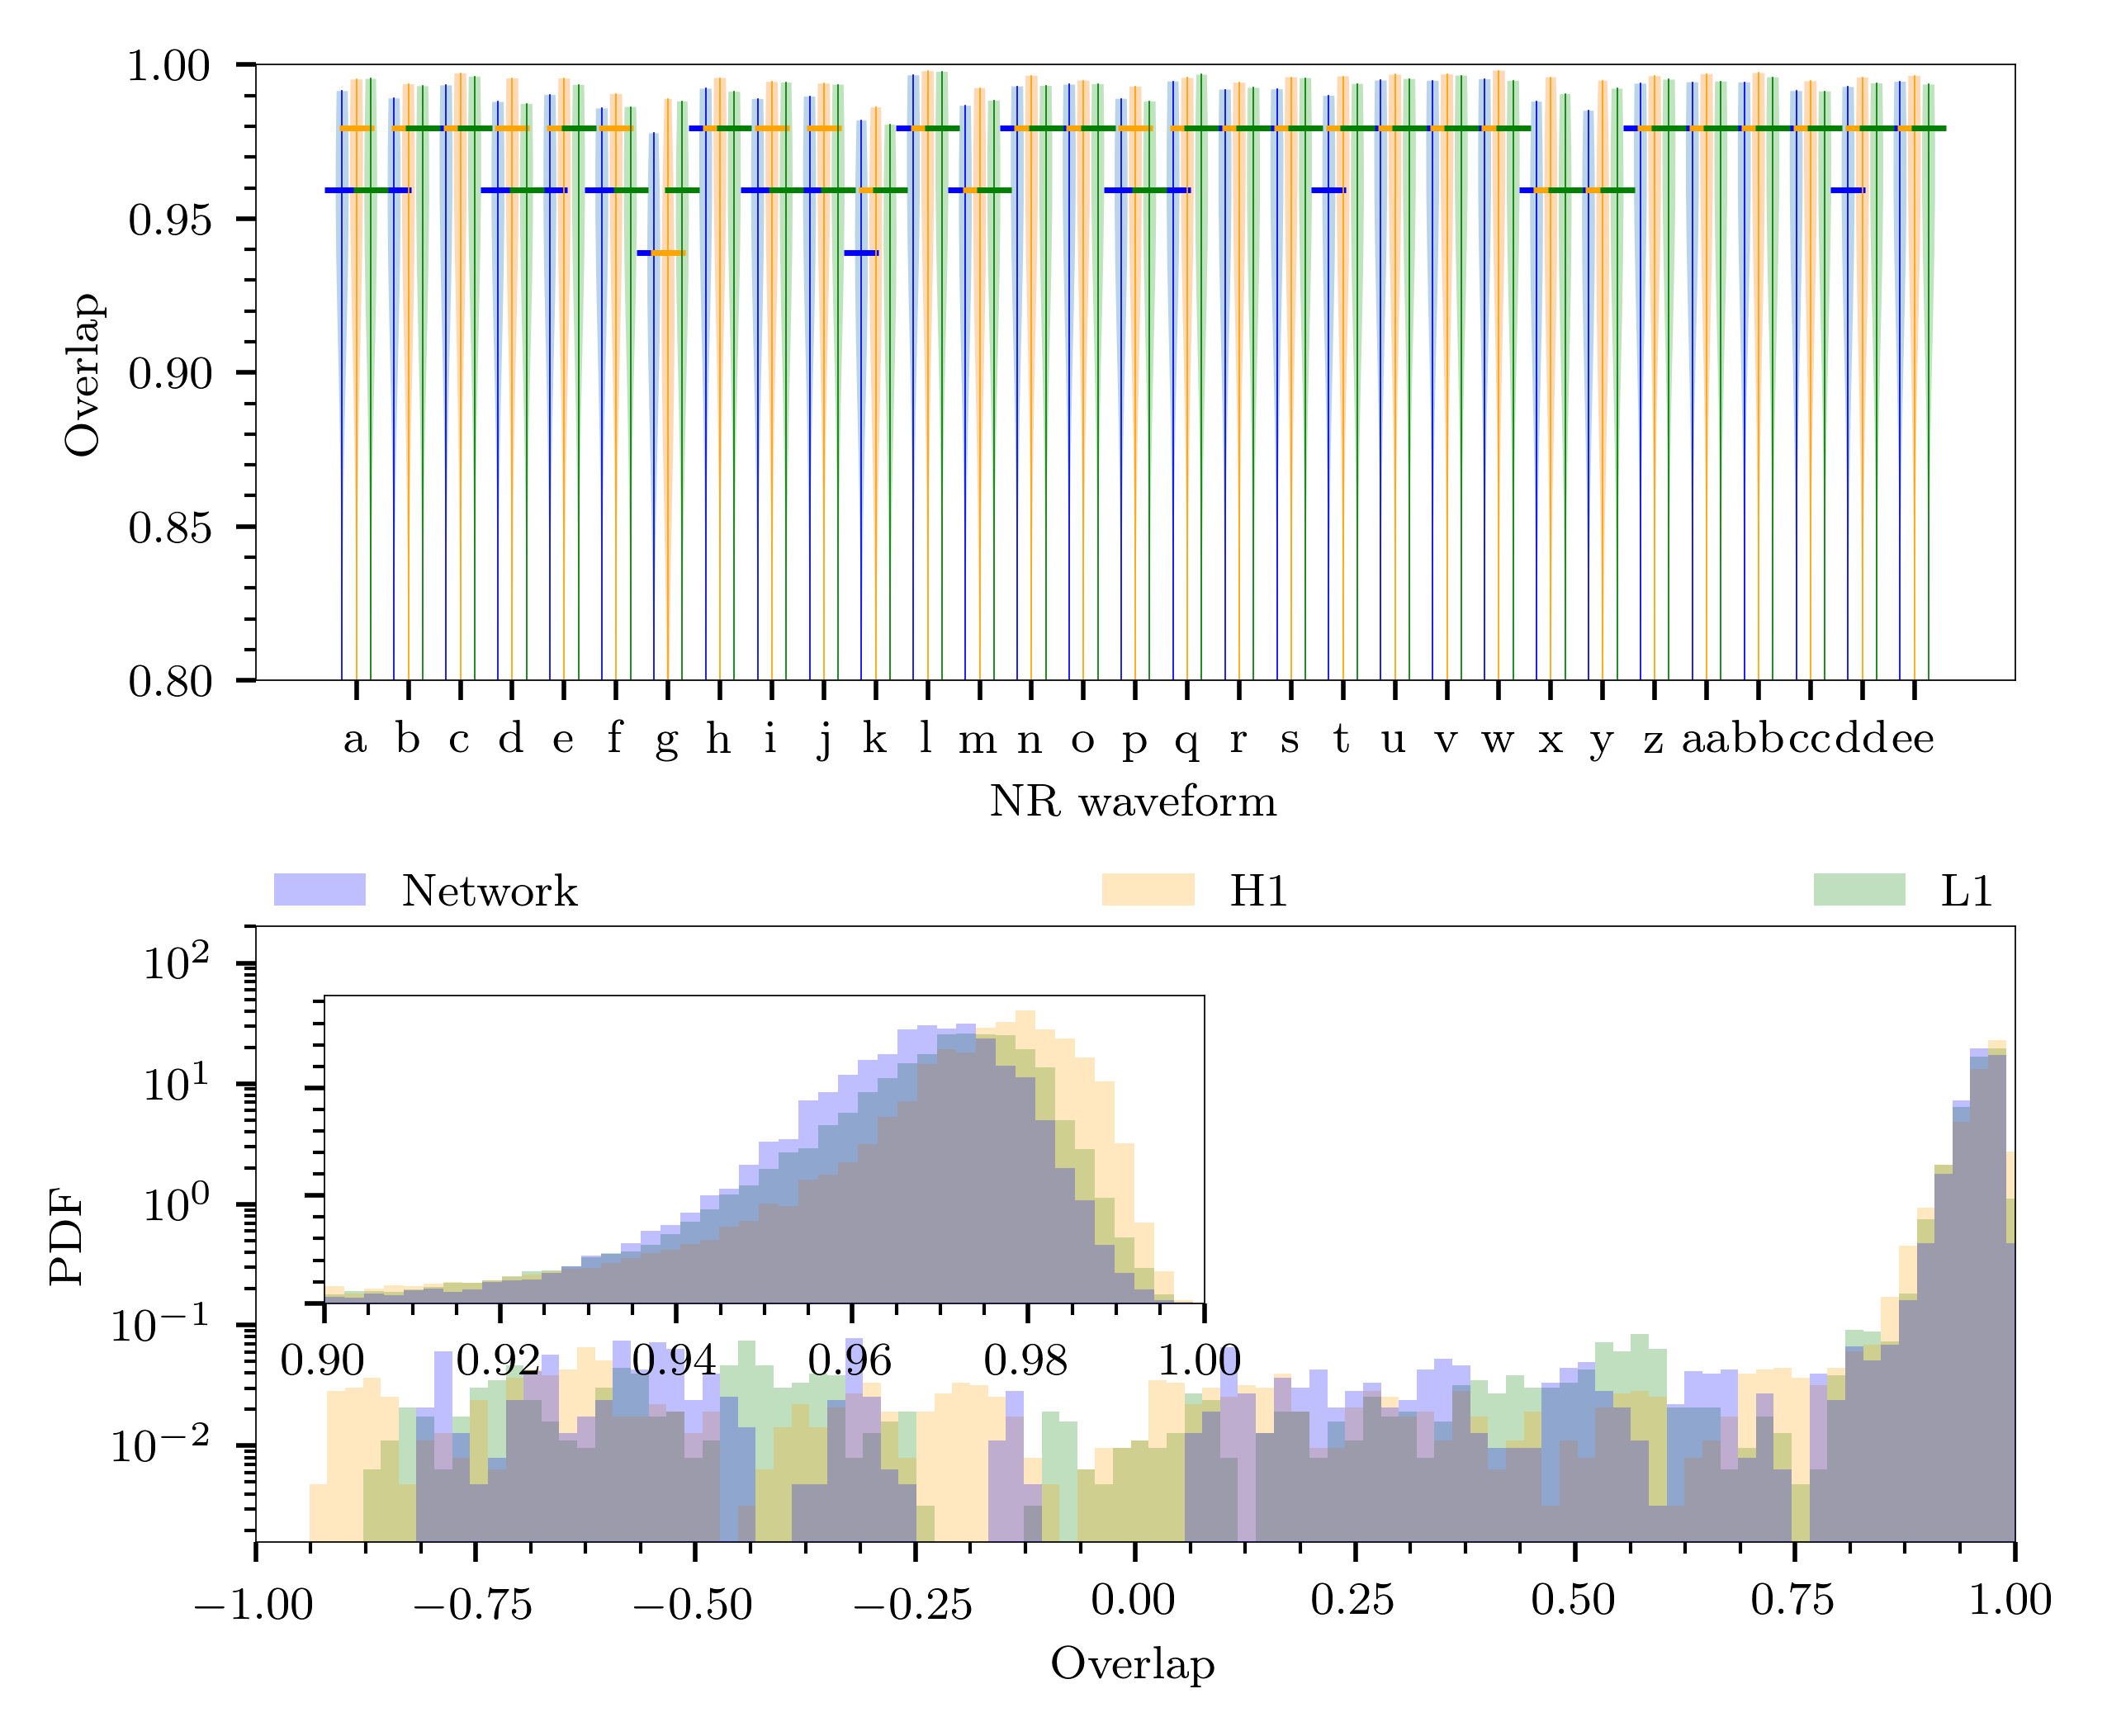

In [15]:
plt.close('all')
f, ax = plt.subplots(dpi=500, nrows=2, figsize=(1.5*fig_size[0], 2*fig_size[1]))
for axis in ['top','bottom','left','right']:
      ax[0].spines[axis].set_linewidth(0.25)
      ax[1].spines[axis].set_linewidth(0.25)
        
widths=5
left_positions = np.arange(0,20*nNRwaves,20)
center_positions = left_positions+widths+0.5
right_positions = center_positions+widths+0.5
single_positions = [center_positions, right_positions]

colors=['blue','orange','green']

print len(left_positions)
print np.shape(li_nr_overlaps)

ax[0].violinplot(li_nr_overlaps.T, 
                 positions=left_positions,
                 showmeans=False, showmedians=False,
                 widths=widths, showextrema=False)

for n in xrange(nNRwaves):

    # Extremea
    maxpt = max(li_nr_overlaps[n])
    minpt = min(li_nr_overlaps[n])
    ax[0].plot([left_positions[n], left_positions[n]], [minpt, maxpt],
               color=colors[0], linewidth=0.25)
    
    # Histogram peaks
    counts, bins = np.histogram(li_nr_overlaps[n],bins=overlap_bins)
    ax[0].plot(left_positions[n], 
               bins[1:][np.argmax(counts)]-0.5*np.diff(bins[1:])[0],
               color=colors[0], marker='_')

# --- Single IFO
overlaps = [li_nr_overlaps_h, li_nr_overlaps_l]
for i in xrange(len(ifos)):

    ax[0].violinplot(overlaps[i].T, 
                     positions=single_positions[i],
                     showmeans=False, showmedians=False,
                     widths=widths, showextrema=False)
    
    for n in xrange(nNRwaves):
        maxpt = max(overlaps[i][n])
        minpt = min(overlaps[i][n])
        ax[0].plot([single_positions[i][n], single_positions[i][n]], 
                   [minpt, maxpt],
                   color=colors[i+1], linewidth=0.25)
        
        # Histogram peaks
        counts, bins = np.histogram(overlaps[i][n],bins=overlap_bins)
        peakloc = bins[1:][np.argmax(counts)]-0.5*np.diff(bins[1:])[0]
        ax[0].plot(single_positions[i][n], 
                   peakloc,
                   color=colors[i+1], marker='_')


ax[0].minorticks_on()
ax[0].set_xticks(center_positions)


labels = [r"$\textrm{%s}$"%waveform_labels[v] 
          for v in xrange(len(ax[0].get_xticklabels()))]
ax[0].set_xticklabels(labels)
ax[0].tick_params(which='minor',bottom="off")

ax[0].set_ylim(.8,1)
ax[0].set_xlabel(r'$\textrm{NR waveform}$')
ax[0].set_ylabel(r'$\textrm{Overlap}$')

# --- Histogram
axins = inset_axes(ax[1], width="50%", height="50%", 
                       loc=2, borderpad=1.5) 
for axis in ['top','bottom','left','right']:
      axins.spines[axis].set_linewidth(0.25)
ax[1].hist(np.concatenate(li_nr_overlaps), 
           histtype='stepfilled', alpha=0.25, bins=overlap_bins, normed=True,
          label=r'$\textrm{Network}$', color=colors[0], zorder=3)
axins.hist(np.concatenate(li_nr_overlaps), 
           histtype='stepfilled', alpha=0.25, bins=inset_bins, normed=True,
           color=colors[0], zorder=3)
for i in xrange(len(ifos)):
    ax[1].hist(np.concatenate(overlaps[i]), normed=True,
               histtype='stepfilled', alpha=0.25, bins=overlap_bins,
               label=r'$\textrm{%s}$'%ifos[i],
               color=colors[i+1], zorder=len(ifos)-i)
    axins.hist(np.concatenate(overlaps[i]), normed=True,
               histtype='stepfilled', alpha=0.25, bins=inset_bins,
               color=colors[i+1], zorder=len(ifos)-i)
    
ax[1].set_yscale('log')

ax[1].minorticks_on()
ax[1].set_xlim(-1,1)
ax[1].set_ylim(0,200)
axins.set_xlim(.9,1)
axins.set_yticklabels([])
axins.minorticks_on()

ax[1].spines['bottom'].set_visible(True)
# ax[1].grid(which='major', color='gray', alpha=0.5)
ax[1].set_xlabel(r'$\textrm{Overlap}$')
ax[1].set_ylabel(r'$\textrm{PDF}$')
# ax[1].legend(loc='upper left')
ax[1].legend(bbox_to_anchor=(0., .99, 1., .102), loc=3,
              ncol=3, mode="expand", borderaxespad=0., 
              frameon=False)

f.tight_layout()
f.subplots_adjust(hspace=.4)

f.savefig("{}_NRoverlapViolins.png".format(approx))
f.savefig("{}_NRoverlapViolins.pdf".format(approx))
    
from IPython.display import Image, display
display(Image(filename="{}_NRoverlapViolins.png".format(approx), width=600))



### Per-waveform histograms

In [16]:

for n,wavename in enumerate(nr_waves_dict.keys()):
    print "histogramming ", wavename
    
    plt.close('all')
    fig, ax = plt.subplots(dpi=500, figsize=fig_size)  
    axins = inset_axes(ax, width="50%", height="50%", 
                       loc=2, borderpad=2)  
    for axis in ['top','bottom','left','right']:
          ax.spines[axis].set_linewidth(0.25)
          axins.spines[axis].set_linewidth(0.25)
            
    ax.hist(li_nr_overlaps[n],bins=overlap_bins, normed=True,
               histtype='stepfilled', alpha=0.25,
               label=r'$\textrm{Network}$',
               color=colors[0], zorder=3)
    axins.hist(li_nr_overlaps[n],bins=inset_bins, normed=True,
               histtype='stepfilled', alpha=0.25,
               color=colors[0], zorder=3)
    
    overlaps = [li_nr_overlaps_h[n], li_nr_overlaps_l[n]]
    for i in xrange(len(ifos)):

        ax.hist(overlaps[i], normed=True,
               histtype='stepfilled', alpha=0.25, bins=overlap_bins,
               label=r'$\textrm{%s}$'%ifos[i],
               color=colors[i+1], zorder=len(ifos)-i)
        axins.hist(overlaps[i],bins=inset_bins, normed=True,
                   histtype='stepfilled', alpha=0.25,
                   color=colors[i+1], zorder=len(ifos)-i)
        axins.set_xlim(0.9,1)
    
    ax.set_yscale('log')
    namestr=r"$\textrm{%s: %s}$"%(
        waveform_labels[n],wavename.replace("_","\_").replace('lmax3-',''))
    fig.text(0.2, 0.875, namestr, 
         va='center', rotation='horizontal')
    ax.minorticks_on()
    axins.minorticks_on()
    ax.set_xlim(-1,1)
    ax.set_ylim(0,30)
    axins.set_xlim(0.9,1)
    axins.set_ylim(0,50)
    axins.set_yticklabels([])
#     ax.grid(which='minor',linestyle='-',color='gray',alpha=0.25)
    ax.set_xlabel(r'$\textrm{Overlap}$')
    ax.set_ylabel(r'$\textrm{PDF}$')
    ax.legend(bbox_to_anchor=(0., .99, 1., .102), loc=3,
              ncol=3, mode="expand", borderaxespad=0., 
              frameon=False)
    
    fig.tight_layout()
#     plt.show()
#     sys.exit()

    fig.tight_layout()
    fig.savefig(wavename+"_{}_hist.png".format(approx))

histogramming  RIT-Generic_D14.53_q0.7147_a0.2205_-0.7110_opt2_n100
histogramming  RIT-Generic_D13.50_q0.4300_a-0.3634_-0.1256_opt2_n118
histogramming  GT-Aligned-UnequalMass_-0.2-1-M200-D11
histogramming  RIT-Kicks_q50_a0_a8_th_135_ph_30
histogramming  RIT-Kicks_q200_a8_a0_th_135_ph_120
histogramming  SXS-All_52
histogramming  LVC-GitAnnex_SXS_BBH_0628_Res3.h5
histogramming  RIT-Generic_d0_D10.52_q1.3333_a-0.25_n100
histogramming  SXS-All_BBH_CFMS_d16.8_q2_sA_0_0_-0.300_sB_0_0_-0.300
histogramming  RIT-Generic_D13.03_UID3_q0.48_a1_0.08_-0.40_-0.30_a2_-0.38_0.75_-0.10_opt2_n100
histogramming  RIT-Kicks_q50_a0_a8_th_135_ph_0
histogramming  RIT-Generic_D14.66_q0.8514_a0.7343_-0.8267_opt2_n100
histogramming  GT-Aligned-UnequalMass_-0.4-1-M200-D11
histogramming  GT-Aligned-UnequalMass_0.0-1.15
histogramming  RIT-Generic_D11.92_UID2_q0.52_a1_0.16_-0.10_-0.05_a2_-0.36_0.57_-0.35_opt2_n100
histogramming  LVC-GitAnnex_SXS_BBH_0627_Res3.h5
histogramming  LVC-GitAnnex_SXS_BBH_0625_Res3.h5
histog

## Waveform plots

### Whitened Approximant & NR

(2, 3, 8192)


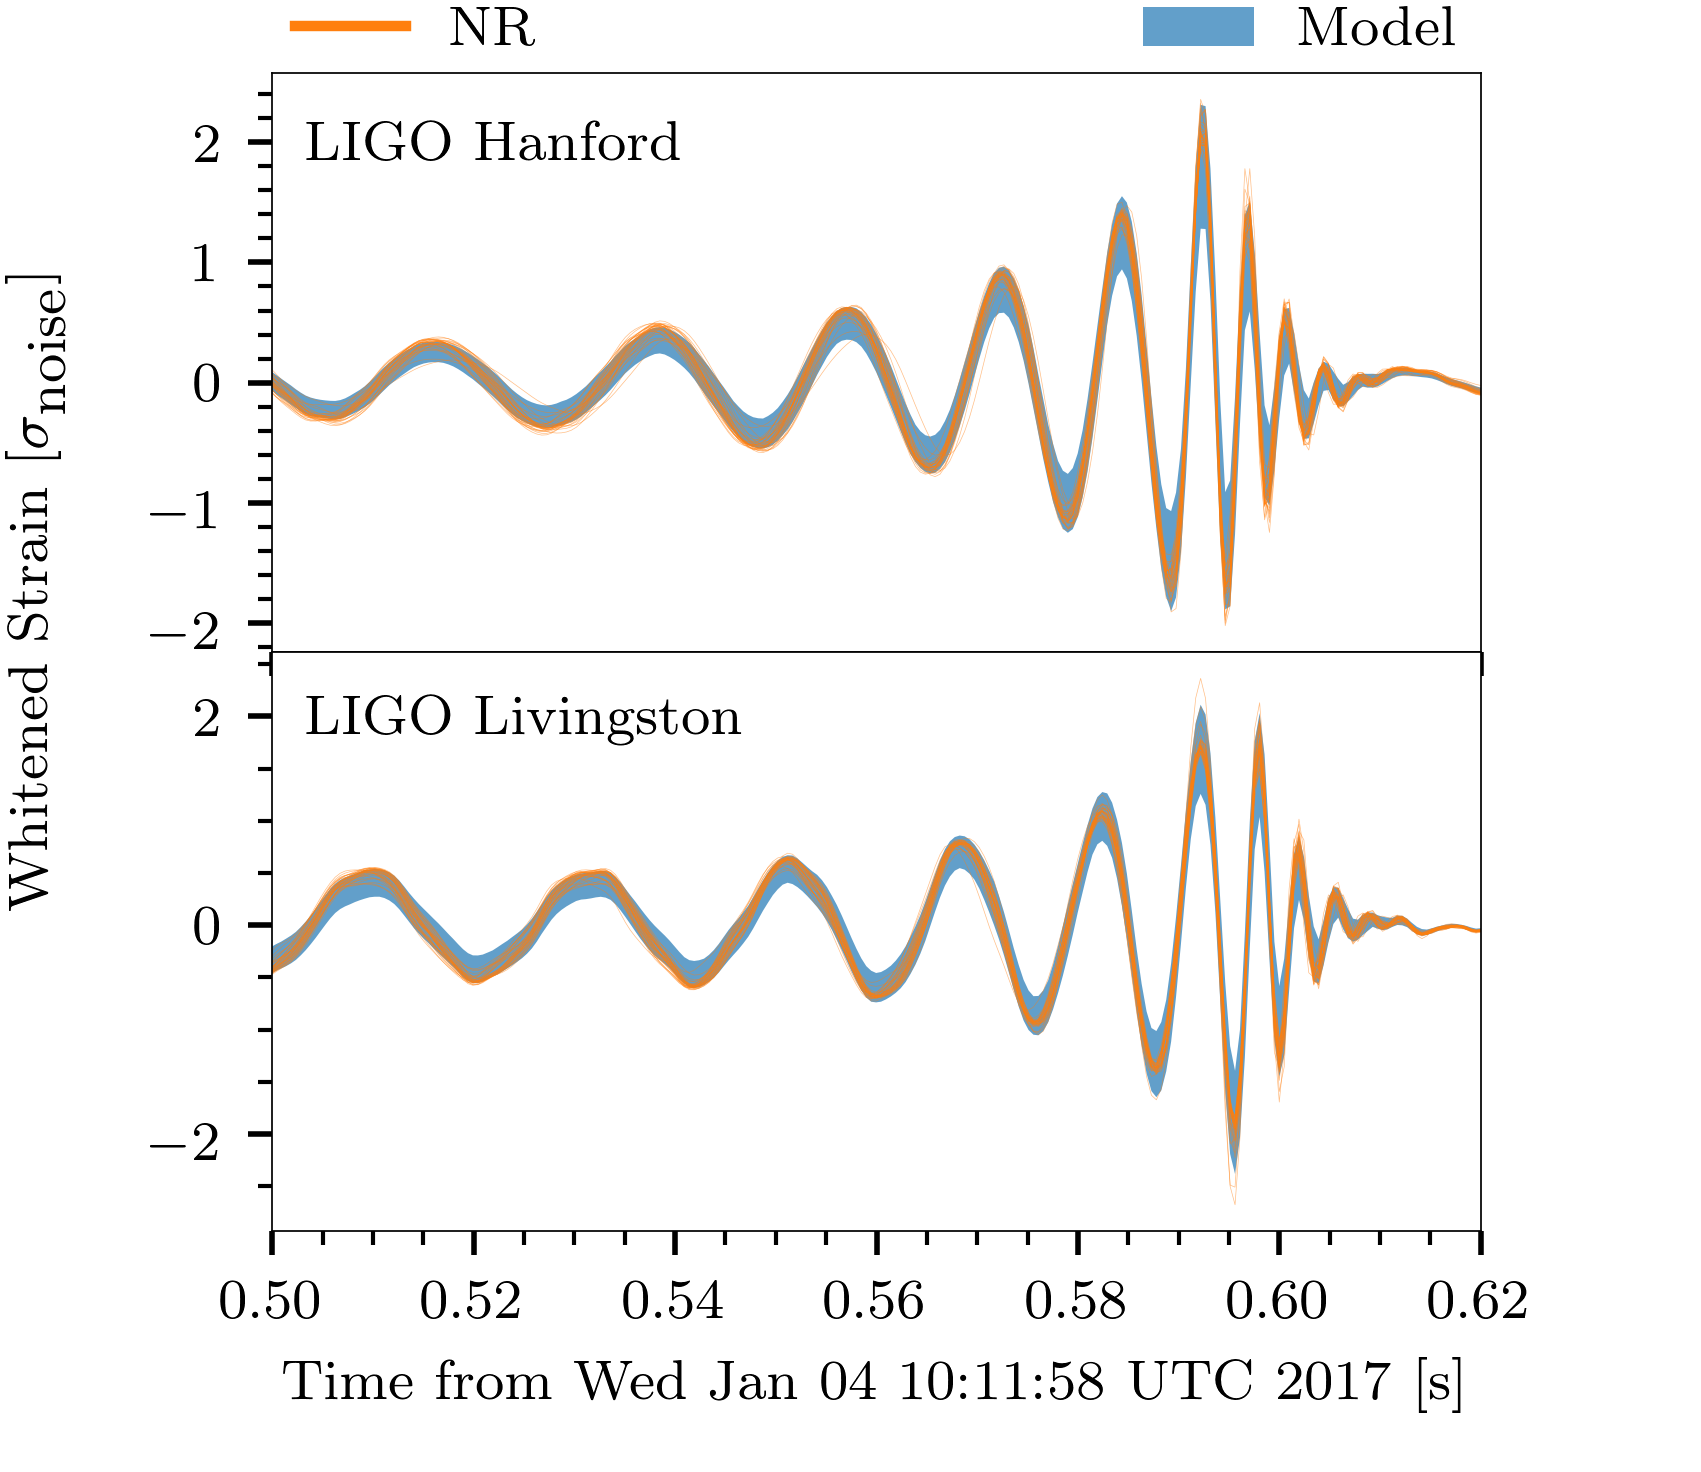

In [17]:
if approx=="IMRPhenomPv2andSEOBNRv3":
    wflabel="Model"
else: wflabel=approx

longnames=[r'$\textrm{LIGO Hanford}$', 
           r'$\textrm{LIGO Livingston}$']

plt.close('all')
fig, ax = plt.subplots(nrows=2, dpi=500, sharex=True,
                     figsize=(fig_size[0],fig_size[1]*1.4))
for axis in ['top','bottom','left','right']:
      ax[0].spines[axis].set_linewidth(0.25)
      ax[1].spines[axis].set_linewidth(0.25)
        
f.subplots_adjust(hspace=0)
print np.shape(li_intervals)
for i in xrange(len(ifos)):
    # LALInference Result
    
    ax[i].fill_between(local_times, li_intervals[i][0],
        li_intervals[i][2], alpha=0.7, 
                       label=r'$\textrm{%s}$'%wflabel, 
        zorder=1, lw=0, color=u'#1f77b4')

    # Try plotting waveforms with alpha=likelihood
    for n in xrange(nNRwaves):
        ax[i].plot(local_times, nr_waves[n][i], 
                   zorder=2, color=u'#ff7f0e', alpha=0.5,
                  lw=0.1)
    
    ax[i].minorticks_on()
    ax[i].set_xlim(0.5,0.62)
#     ax[i].set_ylim(-2.5,2.5)
    
labelstr=r"$\textrm{Whitened Strain }[\sigma_{\textrm{noise}}]$"
fig.text(0.01, 0.6, labelstr, va='center', 
             rotation='vertical')

fig.text(0.18, 0.9, r"$\textrm{LIGO Hanford}$", 
             va='center', rotation='horizontal')
fig.text(0.18, 0.51, r"$\textrm{LIGO Livingston}$", 
             va='center', rotation='horizontal')
    
ax[0].plot(-1,-1,color=u'#ff7f0e',label=r'$\textrm{NR}$')
ax[0].legend(bbox_to_anchor=(0., .99, 1., .102), loc=3,
                   ncol=2, mode="expand", borderaxespad=0., frameon=False)

ax[1].set_xlabel(r'$\textrm{Time from %s [s]}$'%timestr, color='k')
    
fig.tight_layout()
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(left=0.16)
fig.subplots_adjust(right=0.87)
fig.subplots_adjust(top=0.95)

fig.savefig("{}_NRwaveforms.png".format(approx))
fig.savefig("{}_NRwaveforms.pdf".format(approx))
    
from IPython.display import Image, display
display(Image(filename="{}_NRwaveforms.png".format(approx), width=600))


### Raw

(2, 3, 8192)


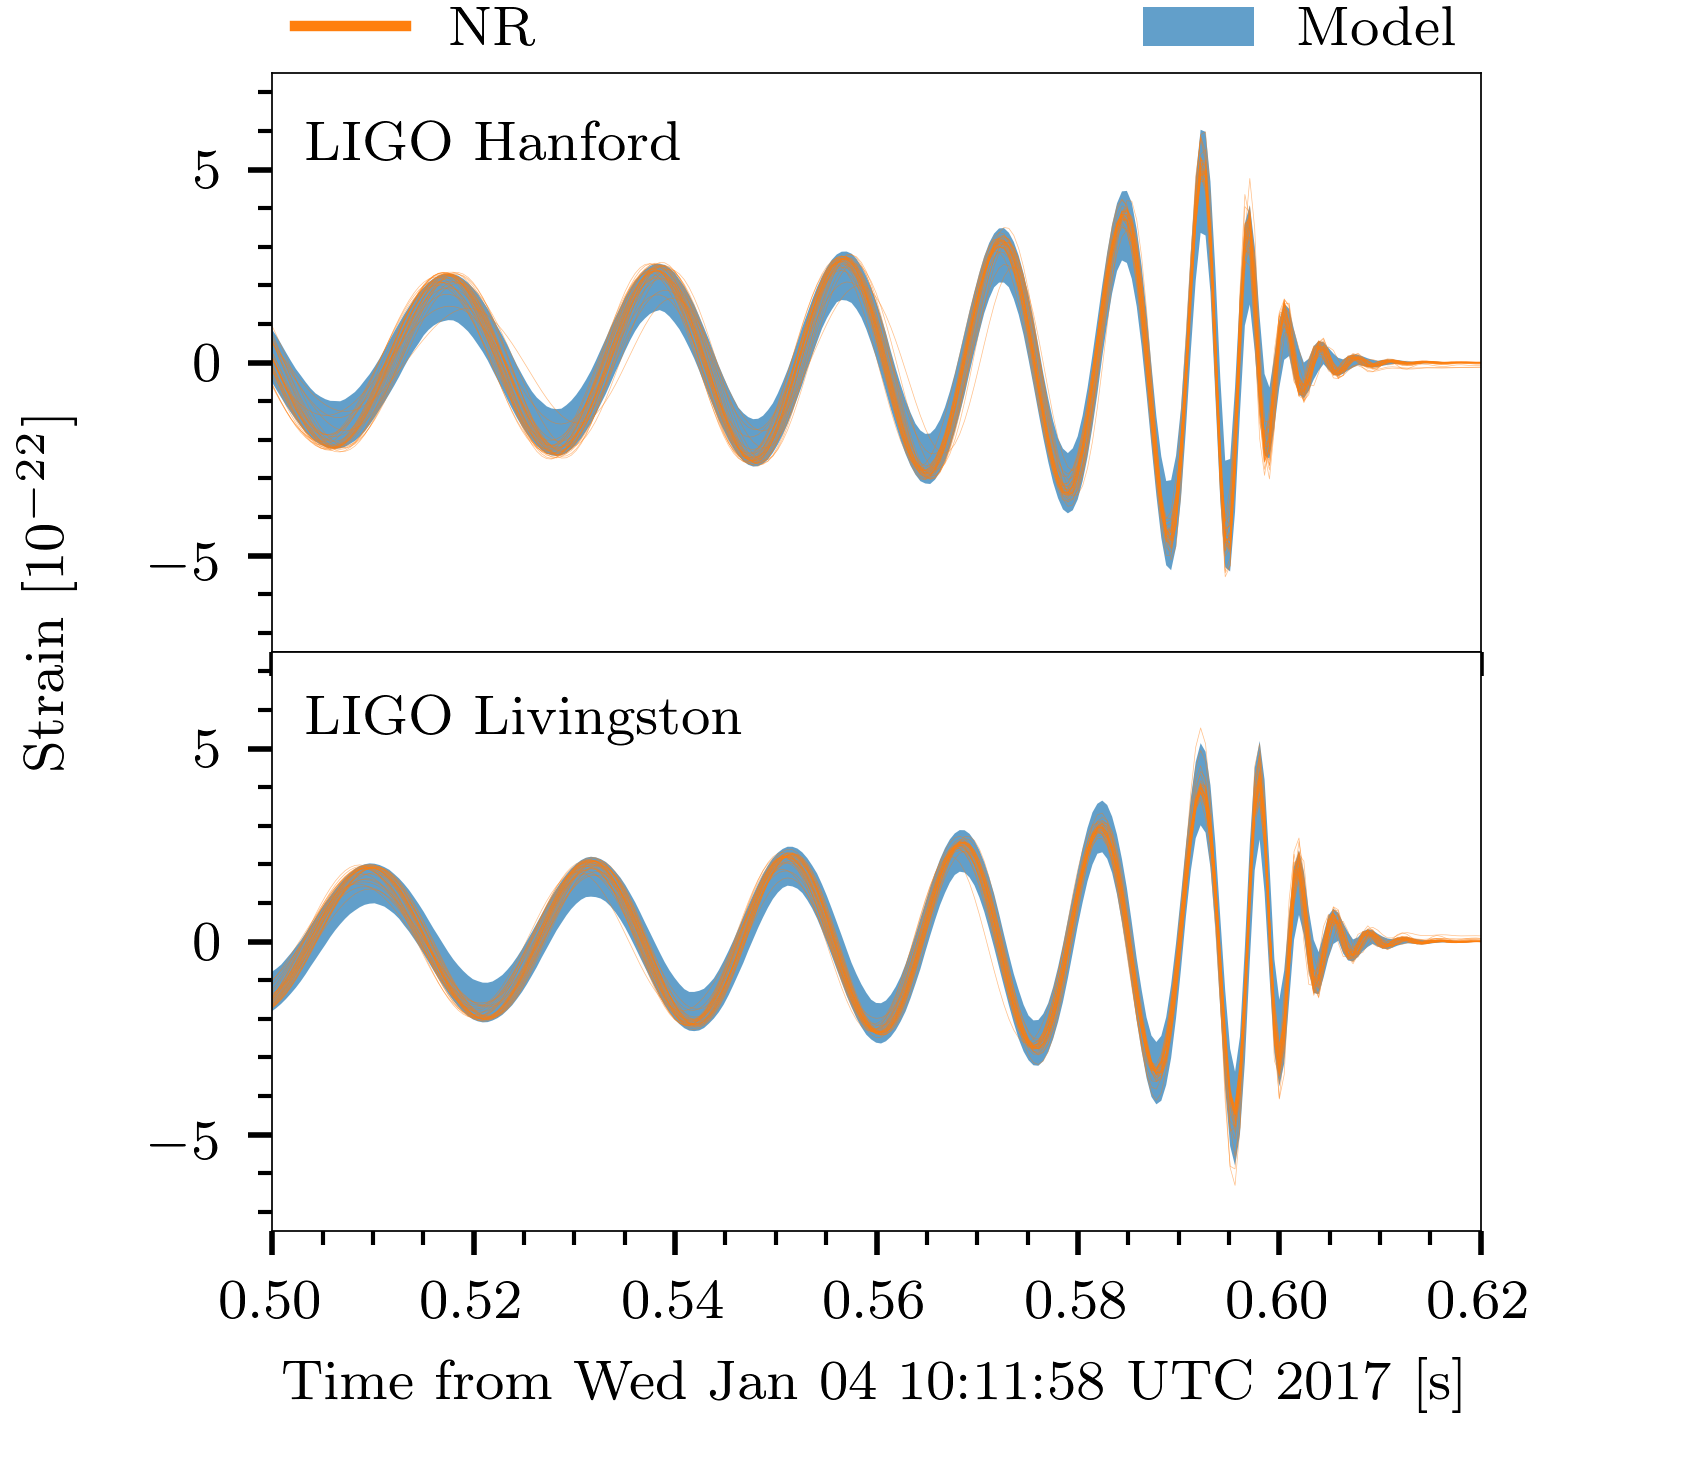

In [18]:
if approx=="IMRPhenomPv2andSEOBNRv3":
    wflabel="Model"
else: wflabel=approx
    
longnames=[r'$\textrm{LIGO Hanford}$', 
           r'$\textrm{LIGO Livingston}$']

plt.close('all')
fig, ax = plt.subplots(nrows=2, dpi=500, sharex=True,
                     figsize=(fig_size[0],fig_size[1]*1.4))
for axis in ['top','bottom','left','right']:
      ax[0].spines[axis].set_linewidth(0.25)
      ax[1].spines[axis].set_linewidth(0.25)
        
f.subplots_adjust(hspace=0)
print np.shape(li_intervals)
for i in xrange(len(ifos)):
    # LALInference Result
    
    ax[i].fill_between(local_times, 1e22*li_intervals_raw[i][0],
        1e22*li_intervals_raw[i][2], alpha=0.7, 
                       label=r'$\textrm{%s}$'%wflabel, 
        zorder=1, lw=0, color=u'#1f77b4')

    # Try plotting waveforms with alpha=likelihood
    for n in xrange(nNRwaves):
        ax[i].plot(local_times, 1e22*nr_waves_raw[n][i], 
                   zorder=2, color=u'#ff7f0e', alpha=0.5,
                  lw=0.1)
    
    ax[i].minorticks_on()
    ax[i].set_xlim(0.5,0.62)
    ax[i].set_ylim(-7.5,7.5)
    
labelstr=r"$\textrm{Strain }[10^{-22}]$"
fig.text(0.01, 0.6, labelstr, va='center', 
             rotation='vertical')

fig.text(0.18, 0.9, r"$\textrm{LIGO Hanford}$", 
             va='center', rotation='horizontal')
fig.text(0.18, 0.51, r"$\textrm{LIGO Livingston}$", 
             va='center', rotation='horizontal')
    
ax[0].plot(-1,-1,color=u'#ff7f0e',label=r'$\textrm{NR}$')
ax[0].legend(bbox_to_anchor=(0., .99, 1., .102), loc=3,
                   ncol=2, mode="expand", borderaxespad=0., frameon=False)

ax[1].set_xlabel(r'$\textrm{Time from %s [s]}$'%timestr, color='k')
    
fig.tight_layout()
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(left=0.16)
fig.subplots_adjust(right=0.87)
fig.subplots_adjust(top=0.95)

fig.savefig("{}_rawNRwaveforms.png".format(approx))
fig.savefig("{}_rawNRwaveforms.pdf".format(approx))
    
from IPython.display import Image, display
display(Image(filename="{}_rawNRwaveforms.png".format(approx), width=600))
